In [1]:
import sounddevice as sd
import soundfile as sf
import soundfile as sf
from scipy import signal 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def getIndex(samplerate, seconds=0, minutes=0, hours=0):
    return samplerate*(seconds + minutes*60 + hours*3600)

In [3]:
def getTime(samplerate, index):
    s_idx = index / samplerate
    hours = s_idx // 3600
    minutes = (s_idx - hours*3600) // 60
    seconds = (s_idx - hours*3600 - minutes * 60)
    return [hours, minutes, seconds]

In [3]:
fs = 24000
window_size = 256
overlap = 0.875
noverlap = int(np.floor(window_size * overlap))
print(noverlap)

file_num = 11

filenm = f'/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/2018-08-14/b8p2male-b10o15female_{file_num}_SdrChannels.w64'
strength_filenm = f'/home/bukaya/ethz/ns/b8p2male-b10o15female_aligned/2018-08-14/b8p2male-b10o15female_{file_num}_SdrChannels.w64'

224


In [6]:
with open(filenm, 'rb') as f:  
    Audiodata, _samplerate_bad = sf.read(f)
    
cur_audio_mic  = Audiodata[40032000:40080000, 0]
cur_audio_bird1 = Audiodata[40032000:40080000, 1]
cur_audio_bird2 = Audiodata[40032000:40080000, 2]

In [7]:
with open(strength_filenm, 'rb') as f:  
    Strengthdata, _samplerate_bad = sf.read(f)

cur_stren_mic  = Strengthdata[:,0]
cur_stren_bird1 = Strengthdata[:,1]
cur_stren_bird2 = Strengthdata[:,2]

In [128]:
print(getIndex(24000, minutes=27, seconds=48))
print(getIndex(24000, minutes=27, seconds=50))
print(getTime(24000, 37920000))
print(getTime(24000, 41400000))

40032000
40080000
[0.0, 26.0, 20.0]
[0.0, 28.0, 45.0]


In [10]:
f, t, Sxx = signal.spectrogram(cur_audio_bird1, fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
plt.pcolormesh(t, f, 20 * np.log10(1. + Sxx))

In [20]:
f, t, Sxx = signal.spectrogram(cur_audio_bird1, fs)
plt.pcolormesh(t, f, 20 * np.log10(1. + Sxx))

In [28]:
f, t, Sxx = signal.spectrogram(cur_audio_bird2, fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
plt.pcolormesh(t, f, 20 * np.log10(1. + Sxx))

In [26]:
f, t, Sxx = signal.spectrogram(cur_audio_bird2, fs)
plt.pcolormesh(t, f, 20 * np.log10(1. + Sxx))

(129, 214)

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(cur_audio_mic)
axs[0, 1].pcolormesh(t, f, Sxx)

# Set DC component to zero
Sxx[0,:] = 0

t_inv, mic_inv = signal.istft(Sxx, fs=fs, window=signal.hamming(window_size, sym=False), nfft=window_size, noverlap=noverlap)

axs[1, 0].plot(mic_inv)
axs[1, 1].pcolormesh(t, f, Sxx)

# Save as .w64 file at correct sampling rate
sf.write('/home/bukaya/ethz/ns/vocal-recon/mic11_inv_sub.w64', mic_inv, fs)

In [4]:
with open(filenm, 'rb') as f:  
    Audiodata, _samplerate_bad = sf.read(f)
    
mic  = Audiodata[:, 0]
acc_m = Audiodata[:, 1]
acc_f = Audiodata[:, 2]

In [5]:
sos = signal.butter(10, [15, 8000], 'bp', fs=24000, output='sos')
filtered_bp = signal.sosfilt(sos, mic)
#sf.write('/home/bukaya/ethz/ns/vocal-recon/mic11_butterworth_bp_10_15_8000.w64', filtered_bp, fs)

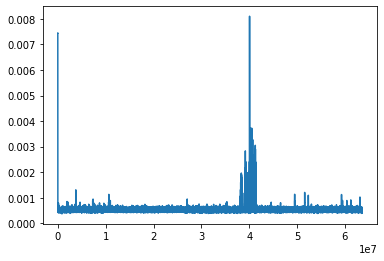

In [6]:
window = 2400
abs_fil = np.absolute(filtered_bp)
mean_pd_abs = pd.Series(abs_fil).rolling(window=window).mean().iloc[window-1:].values
plt.plot(mean_pd_abs)

In [10]:
counter = 0

mic_bp_sht = []
acc_m_sht = []
acc_f_sht = []

for i, j in enumerate(mean_pd_abs):
    if j >= 0.001:
        mic_bp_sht.append(filtered_bp[i + window//2])
        acc_m_sht.append(acc_m[i + window//2])
        acc_f_sht.append(acc_f[i + window//2])
        counter += 1
        
print(counter)
mic_bp_np = np.asarray(mic_bp_sht)
acc_m_np = np.asarray(acc_m_sht)
acc_f_np = np.asarray(acc_f_sht)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/11_short_{window}_mic.w64', mic_bp_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/11_short_{window}_acc_m.w64', acc_m_np, fs)
sf.write(f'/home/bukaya/ethz/ns/vocal-recon/11_short_{window}_acc_f.w64', acc_f_np, fs)

314078


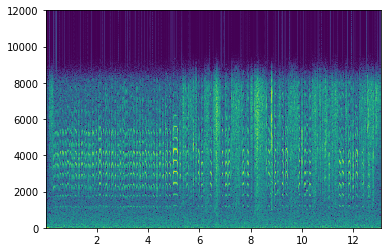

In [60]:
window_size = 1024

f, t, Sxx = signal.spectrogram(mic_bp_np, fs , window=signal.hamming(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
#f, t, Sxx = signal.spectrogram(mic_bp_np, fs )
'''
print(f.shape)
print(f)
print(t.shape)
print(t)
print(Sxx.shape)
print(Sxx)
'''

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
plt.pcolormesh(t, f, np.log10(0.000000000001 + Sxx))

(314078,)


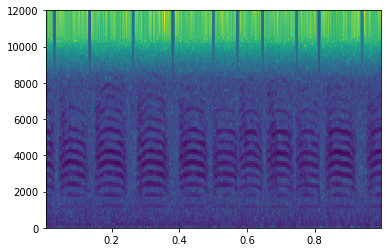

In [95]:
window_size = 240
print(mic_bp_np.shape)
f, t, Sxx = signal.spectrogram(mic_bp_np[fs:2*fs], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
#f, t, Sxx = signal.spectrogram(mic_bp_np, fs )
'''
print(f.shape)
print(f)
print(t.shape)
print(t)
print(Sxx.shape)
print(Sxx)
'''

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
Sxa = -7 * np.log10(Sxx)
Sxb = np.log10((10**-7)+Sxx)
plt.pcolormesh(t, f, Sxa)
plt.savefig('exp_inv_mic.png')

(314078,)


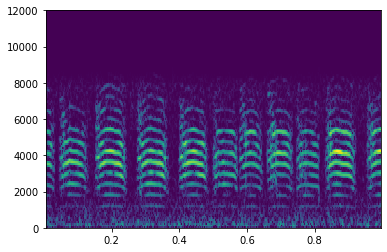

In [82]:
window_size = 240
print(mic_bp_np.shape)
f, t, Sxx = signal.spectrogram(mic_bp_np[fs:2*fs], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
#f, t, Sxx = signal.spectrogram(mic_bp_np, fs )
'''
print(f.shape)
print(f)
print(t.shape)
print(t)
print(Sxx.shape)
print(Sxx)f
'''

#plt.pcolormesh(t, f[:80], 20 * np.log10(1 + Sxx[:80,:]))
plt.pcolormesh(t, f, np.log10(0.00000001 + Sxx))
plt.savefig('mic.png')

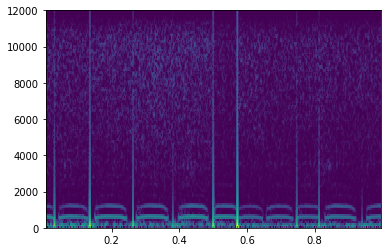

In [83]:
f, t, Sxx = signal.spectrogram(acc_f_np[fs:2*fs], fs , window=signal.hann(window_size, sym=False) , #window=signal.blackman(self.window_size),
                                nfft=window_size, noverlap=noverlap, scaling="spectrum")
plt.pcolormesh(t, f, np.log10(0.00000001 + Sxx))
plt.savefig('acc_f.png')